In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

/home/jose/.local/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('how-long-would-you-stay-data-ft-apr-2021/hospital_train.csv', index_col=0)

In [3]:
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,,,,,,,,,,,,,
161528,6,a,6,X,2,gynecology,R,F,4.0,45810,2.0,Urgent,Moderate,2,21-30,2817.0,0-10
159472,23,a,6,X,4,gynecology,Q,F,2.0,128565,15.0,Trauma,Moderate,4,51-60,4498.0,21-30
309765,2,c,5,Z,2,anesthesia,S,F,3.0,46565,5.0,Urgent,Moderate,2,71-80,4573.0,11-20
279614,32,f,9,Y,3,gynecology,S,B,4.0,124546,6.0,Emergency,Moderate,4,11-20,7202.0,51-60
147791,14,a,1,X,3,gynecology,S,E,2.0,22729,8.0,Urgent,Moderate,2,51-60,3398.0,51-60


In [4]:
df.isna().mean()

1     0.00000
2     0.00000
3     0.00000
4     0.00000
5     0.00000
6     0.00000
7     0.00000
8     0.00000
9     0.00033
10    0.00000
11    0.01483
12    0.00000
13    0.00000
14    0.00000
15    0.00000
16    0.00000
17    0.00000
dtype: float64

In [5]:
# Rellenamos los NaN
impute = SimpleImputer(strategy='most_frequent')
df['9'] = impute.fit_transform(df['9'].values.reshape(-1, 1))
df['11'] = impute.fit_transform(df['11'].values.reshape(-1, 1))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '0-10'),
  Text(1, 0, '21-30'),
  Text(2, 0, '11-20'),
  Text(3, 0, '51-60'),
  Text(4, 0, '31-40'),
  Text(5, 0, '71-80'),
  Text(6, 0, 'More than 100 Days'),
  Text(7, 0, '41-50'),
  Text(8, 0, '81-90'),
  Text(9, 0, '61-70'),
  Text(10, 0, '91-100')])

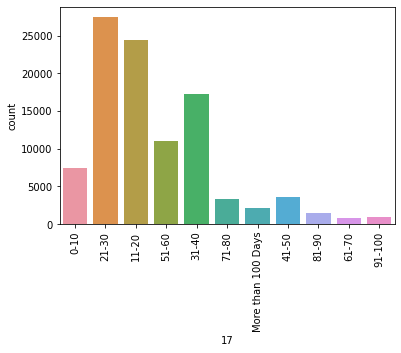

In [6]:
sns.countplot(data=df, x='17')
plt.xticks(rotation=90)

In [7]:
target = df['17']
df.drop('17', axis=1, inplace=True)

In [8]:
# Codificamos la columna 13
df['13'].unique()
diccionario_13 = {'Minor': 0, 'Moderate':1, 'Extreme': 2}
df['13'] = df['13'].apply(lambda x: diccionario_13[x])

In [9]:
#Miramos algunos outliers

<AxesSubplot:xlabel='5'>

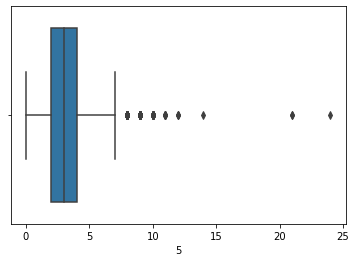

In [10]:
sns.boxplot(data=df, x='5')

<AxesSubplot:xlabel='14'>

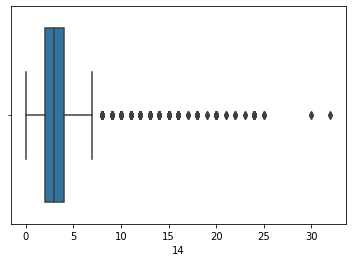

In [11]:
sns.boxplot(data=df, x='14')

<AxesSubplot:xlabel='16'>

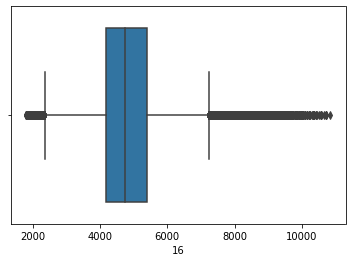

In [12]:
sns.boxplot(data=df, x='16')

In [13]:
# Codificamos la columna target
encoder = LabelEncoder()
target = encoder.fit_transform(target)

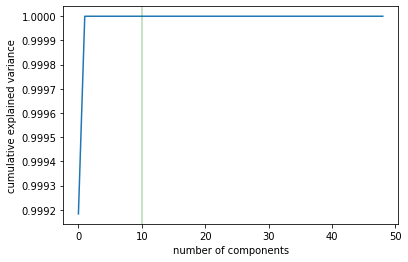

In [14]:
# Diagrama PCA, decido no usarla
pca = PCA()
pca.fit(pd.get_dummies(df))
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance')

In [15]:
scaler = StandardScaler()

In [16]:
df = pd.get_dummies(df)

In [17]:
df_no_dummies = df.iloc[:, :9]
df_dummies = df.iloc[:, 9:]

In [18]:
# Estandarizamos solo las variables numericas
df_no_dummies = pd.DataFrame(scaler.fit_transform(df_no_dummies), columns=df_no_dummies.columns, index=df_no_dummies.index)
df = pd.concat([df_no_dummies, df_dummies], axis=1)

In [19]:
X = df.to_numpy()

Entrenamiento con redes neuronales

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.15, random_state=42)

In [21]:
model = keras.Sequential()
model.add(keras.layers.Dense(32, activation='relu', input_shape=(X.shape[1],)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(11, activation='softmax'))

In [22]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1600      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 11)                187       
Total params: 2,315
Trainable params: 2,315
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [24]:
stop = keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)


In [25]:
history = model.fit(
    X,
    target,
    batch_size=50,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_split=0.2,
    callbacks=stop,
    shuffle=True
)

Epoch 1/100
1600/1600 [==============================] - 3s 1ms/step - loss: 1.9774 - sparse_categorical_accuracy: 0.2678 - val_loss: 1.6354 - val_sparse_categorical_accuracy: 0.3776
Epoch 2/100
1600/1600 [==============================] - 2s 1ms/step - loss: 1.6758 - sparse_categorical_accuracy: 0.3581 - val_loss: 1.6046 - val_sparse_categorical_accuracy: 0.3913
Epoch 3/100
1600/1600 [==============================] - 2s 1ms/step - loss: 1.6437 - sparse_categorical_accuracy: 0.3720 - val_loss: 1.5875 - val_sparse_categorical_accuracy: 0.3974
Epoch 4/100
1600/1600 [==============================] - 2s 1ms/step - loss: 1.6273 - sparse_categorical_accuracy: 0.3774 - val_loss: 1.5839 - val_sparse_categorical_accuracy: 0.3966
Epoch 5/100
1600/1600 [==============================] - 2s 1ms/step - loss: 1.6174 - sparse_categorical_accuracy: 0.3831 - val_loss: 1.5760 - val_sparse_categorical_accuracy: 0.4016
Epoch 6/100
1600/1600 [==============================] - 2s 1ms/step - loss: 1.6051 -

In [26]:
model.evaluate(X_test, y_test)

469/469 [==============================] - 1s 1ms/step - loss: 1.5545 - sparse_categorical_accuracy: 0.4028


[1.5545275211334229, 0.4027999937534332]

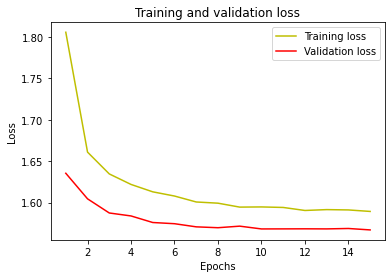

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Probando con Gradient boost

In [ ]:
for i in [10, 50, 100, 200, 500, 1000, 2000]:    
    model2 = ensemble.GradientBoostingClassifier(n_estimators=i, random_state=42)
    model2.fit(X_train, y_train)
    print(i)
    print('score de valiXdación', model2.score(X_test, y_test))
    print('score de entrenamiento', model2.score(X_train, y_train))
    print('-----------------')

In [ ]:
model2 = ensemble.GradientBoostingClassifier(n_estimators=200, random_state=42)
model2.fit(X, target)
model2.score(X, target)

0.43628

In [ ]:
model2.score(X_train, y_train)

0.4356470588235294

In [ ]:
model2.score(X_test, y_test)

0.4398666666666667

## Predicción 

In [ ]:
from sklearn.impute import SimpleImputer

In [29]:
test = pd.read_csv('how-long-would-you-stay-data-ft-apr-2021/hospital_test.csv', index_col=0)

In [30]:
index_test = list(test.index)

In [31]:
test['9'] = impute.fit_transform(test['9'].values.reshape(-1, 1))
test['11'] = impute.fit_transform(test['11'].values.reshape(-1, 1))
test['13'] = test['13'].apply(lambda x: diccionario_13[x])

In [34]:
test = pd.get_dummies(test)
test_no_dummies = test.iloc[:, :9]
test_dummies = test.iloc[:, 9:]
test_no_dummies = pd.DataFrame(scaler.fit_transform(test_no_dummies), columns=test_no_dummies.columns, index=test_no_dummies.index)
test = pd.concat([test_no_dummies, test_dummies], axis=1)

In [35]:
test.shape

(133744, 49)

### 2. Carga los datos de `diamonds_test.csv` para predecir.

**¿De dónde saco `diamonds_test.csv`?**

In [36]:
predictions_submit = model.predict(test)

In [37]:
# El índice del máximo en cada columna representa la categoría con mayor probabilidad
predictions_submit = np.argmax(predictions_submit, axis=1).reshape(-1, 1).copy()

In [38]:
predictions_submit

array([[1],
       [5],
       [1],
       ...,
       [2],
       [2],
       [2]])

In [39]:
predictions_submit.shape

(133744, 1)

In [40]:
submission = pd.DataFrame({"id": index_test, "days": [encoder.inverse_transform(x).item() for x in predictions_submit.reshape(-1, 1)]})

In [41]:
submission.head()

,id,days
0,314114,11-20
1,208989,51-60
2,305872,11-20
3,266099,51-60
4,13228,11-20


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

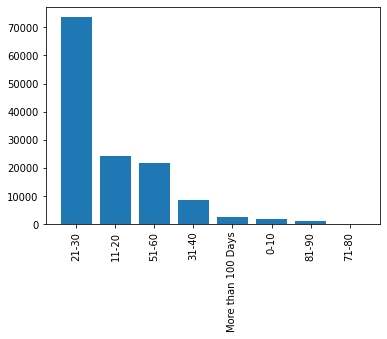

In [42]:
plt.bar(x=submission['days'].value_counts().index, height=submission['days'].value_counts())
plt.xticks(rotation=90)

In [43]:
submission.shape

(133744, 2)

In [ ]:
submission.to_csv('submission.csv', index=False)
